In [1]:
!pip install fastai

from fastai.vision.all import *
import pandas as pd
from pathlib import Path

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
# Mount Google Drive
from google.colab import drive
import pandas as pd
from pathlib import Path

drive.mount('/content/drive')

Mounted at /content/drive


New dataframe with valid image paths and prices:
                                                                 full_image_path  \
0  /content/drive/My Drive/Graduation_data/yolo_mixte_dataset/dataset/000180.jpg   
1  /content/drive/My Drive/Graduation_data/yolo_mixte_dataset/dataset/000274.jpg   
2  /content/drive/My Drive/Graduation_data/yolo_mixte_dataset/dataset/000488.jpg   
3  /content/drive/My Drive/Graduation_data/yolo_mixte_dataset/dataset/001019.jpg   
4  /content/drive/My Drive/Graduation_data/yolo_mixte_dataset/dataset/001153.jpg   

   price  
0    160  
1     75  
2    100  
3     40  
4    120  


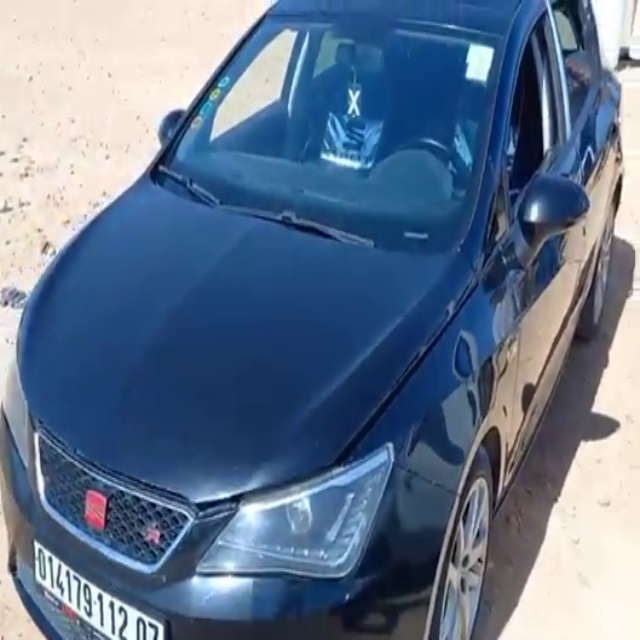

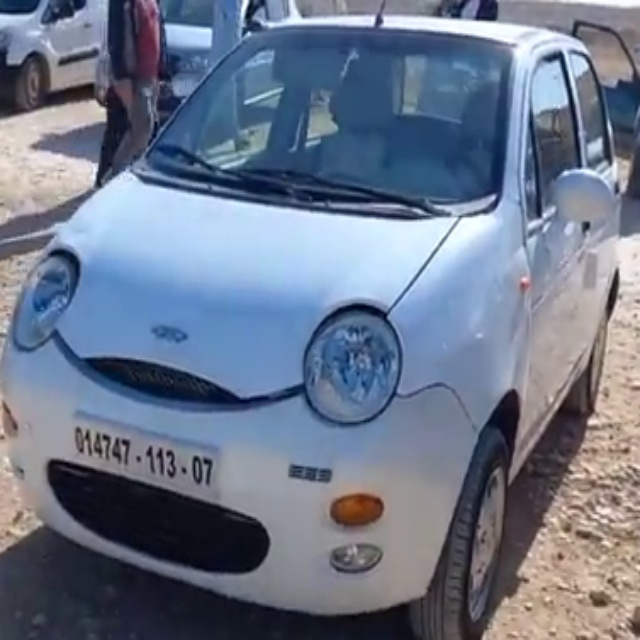

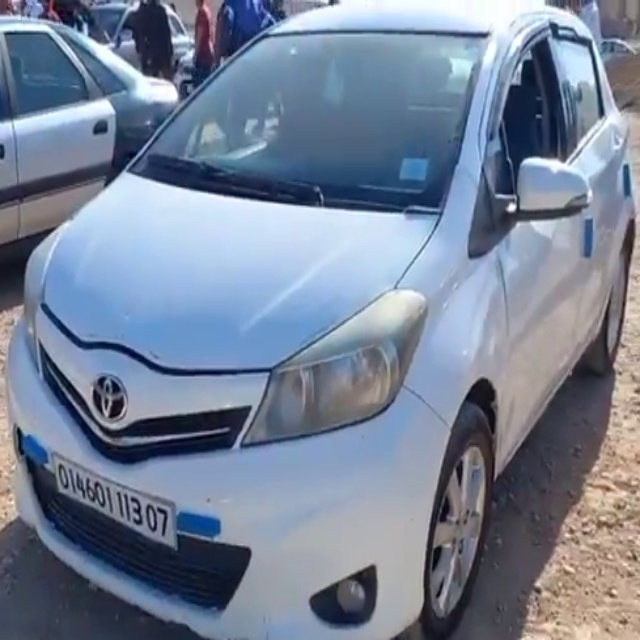

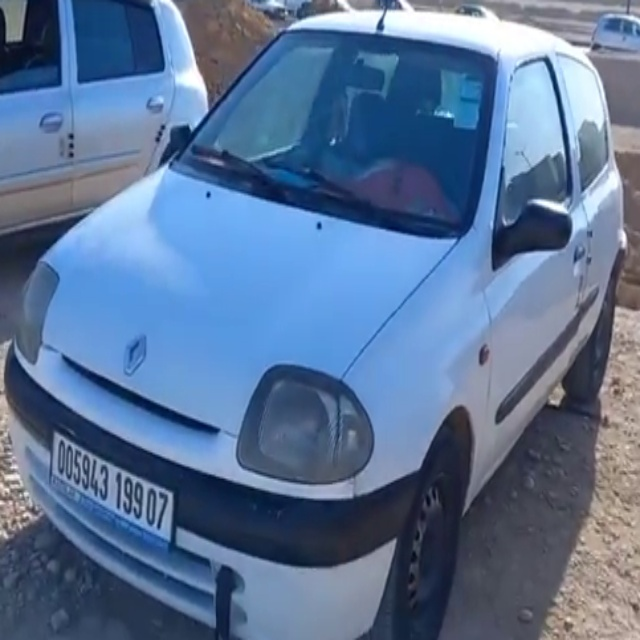

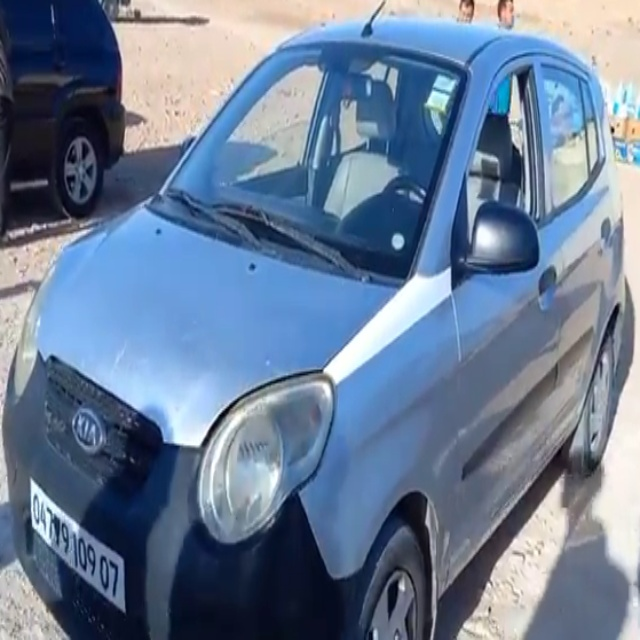

In [3]:
# Import necessary libraries for displaying images
from IPython.display import display
from PIL import Image, UnidentifiedImageError

# Define the paths
cars_data_directory = '/content/drive/My Drive/Graduation_data/yolo_mixte_dataset/'
cars_data_file = Path(cars_data_directory) / 'cars_metadata_rnd.csv'
cars_data_images = '/content/drive/My Drive/Graduation_data/yolo_mixte_dataset/'

# Load the dataset
df = pd.read_csv(cars_data_file)
df.head()

# Extract the filename and price columns
df = df[['filename', 'price']]

# Define a function to get the full image path
def get_image_path(image_name):
    return Path(cars_data_images) / image_name

# Add the full image path to the dataframe
df['full_image_path'] = df['filename'].apply(get_image_path)

# Function to check if an image is valid
def is_image_valid(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is, in fact, an image
        return True
    except (UnidentifiedImageError, IOError):
        return False

# Filter out corrupted images
df['is_valid'] = df['full_image_path'].apply(is_image_valid)
valid_df = df[df['is_valid']].drop(columns=['is_valid'])

# Create a new dataframe with the full image paths and prices
new_df = valid_df[['full_image_path', 'price']]

# Reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

# Display the new dataframe
print("New dataframe with valid image paths and prices:")
print(new_df.head())

# Function to display images
def display_images(image_paths, num_images=5):
    for i in range(num_images):
        img = Image.open(image_paths[i])
        display(img)

# Get the image paths from the dataframe
image_paths = new_df['full_image_path'].tolist()

# Display a few images to check the paths
display_images(image_paths, num_images=5)


In [4]:
new_df.shape

(114, 2)

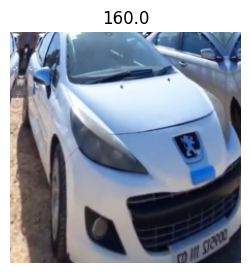

In [5]:
from fastai.vision.all import *

# Define the DataBlock
car_block = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('full_image_path'),
    get_y=ColReader('price'),
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()
)

# Create the DataLoaders
dls = car_block.dataloaders(new_df)
dls.show_batch(max_n=1)

In [6]:
# Define the Model
learn = cnn_learner(dls, resnet34, metrics=rmse)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 207MB/s]


SuggestedLRs(valley=0.007585775572806597)

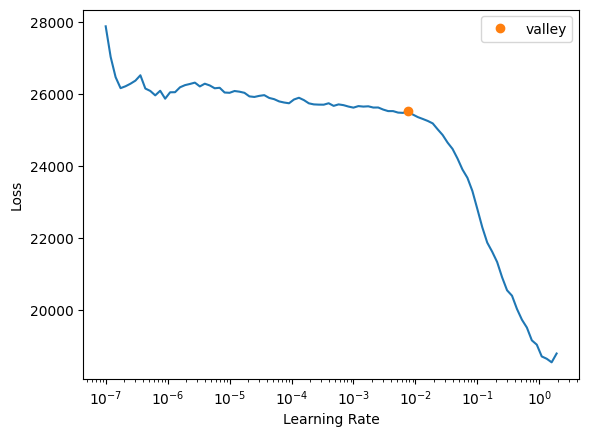

In [7]:
# Finding the optimal learning rate
learn.lr_find()

In [9]:
optimal_lr = 1e-2

# Fine-tune the model with different epochs and optimal learning rate
best_rmse = float('inf')
best_epochs = 0

for epochs in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]:
    learn.fine_tune(epochs, base_lr=optimal_lr)
    preds, targs = learn.get_preds()
    rmse_value = rmse(preds, targs).item()
    print(f"Epochs: {epochs}, RMSE: {rmse_value:.4f}")
    if rmse_value < best_rmse:
        best_rmse = rmse_value
        best_epochs = epochs

print(f"Best number of epochs: {best_epochs}, with RMSE: {best_rmse:.4f}")

epoch,train_loss,valid_loss,_rmse,time
0,727.601562,7226.714355,85.010086,00:01


epoch,train_loss,valid_loss,_rmse,time
0,926.462891,7597.573730,87.164062,00:02
1,671.131470,8080.252930,89.890228,00:02
2,810.854248,9252.543945,96.190140,00:01
3,958.233948,9479.958984,97.365082,00:01
4,913.125122,8570.950195,92.579430,00:01
5,917.910278,7738.913574,87.971092,00:01
6,842.746948,7061.750000,84.034225,00:01
7,803.520325,6852.999512,82.782837,00:02
8,769.890259,6800.305176,82.463966,00:02
9,755.573303,6806.358887,82.500656,00:01


Epochs: 10, RMSE: 82.5007


epoch,train_loss,valid_loss,_rmse,time
0,822.643127,6769.805176,82.278824,00:01


epoch,train_loss,valid_loss,_rmse,time
0,543.342407,6774.693359,82.308525,00:01
1,434.602783,6668.904297,81.663353,00:01
2,526.349854,6702.082520,81.866249,00:01
3,531.182129,6371.727051,79.823097,00:02
4,517.846680,6100.504395,78.105728,00:02
5,508.855011,5961.444824,77.210396,00:01
6,486.425598,6238.755859,78.985786,00:01
7,463.856232,6394.651855,79.966560,00:01
8,461.771454,6292.029785,79.322319,00:01
9,451.024292,6281.240234,79.254272,00:01


Epochs: 20, RMSE: 90.0884


epoch,train_loss,valid_loss,_rmse,time
0,407.476440,8042.410645,89.679482,00:01


epoch,train_loss,valid_loss,_rmse,time
0,339.931213,7828.534180,88.479004,00:01
1,270.361084,7588.390137,87.111359,00:01
2,268.978607,7101.159180,84.268372,00:01
3,265.671875,6488.784180,80.552986,00:02
4,297.368774,6204.882812,78.771080,00:02
5,294.391052,5754.362305,75.857513,00:01
6,273.649261,5402.637695,73.502632,00:01
7,289.363098,5406.935547,73.531868,00:01
8,289.386566,5328.819336,72.998756,00:01
9,295.931671,4971.326660,70.507637,00:01


Epochs: 30, RMSE: 82.2807


epoch,train_loss,valid_loss,_rmse,time
0,220.404938,6838.232422,82.693604,00:02


epoch,train_loss,valid_loss,_rmse,time
0,352.123138,6929.517090,83.243721,00:02
1,401.463837,7115.880859,84.355682,00:01
2,339.655762,7005.596680,83.699448,00:01
3,385.546265,6828.387207,82.634056,00:01
4,387.842010,6984.674805,83.574371,00:01
5,361.523773,6884.609375,82.973549,00:01
6,345.879242,6779.138672,82.335526,00:02
7,325.693909,6543.876465,80.894241,00:02
8,318.639740,6552.910645,80.950050,00:01
9,332.901917,6367.081055,79.793991,00:01


Epochs: 40, RMSE: 86.4932


epoch,train_loss,valid_loss,_rmse,time
0,229.475235,7582.568359,87.077942,00:01


epoch,train_loss,valid_loss,_rmse,time
0,443.103088,7464.517090,86.397430,00:02
1,341.402374,7231.484863,85.038139,00:02
2,325.431519,7076.833984,84.123917,00:01
3,275.832428,6937.224609,83.290001,00:01
4,265.359558,6880.032715,82.945969,00:01
5,250.070740,6942.270020,83.320290,00:01
6,257.687531,7018.750000,83.777977,00:01
7,266.268494,6979.735840,83.544815,00:02
8,270.097321,7212.636230,84.927246,00:02
9,277.705963,7395.745605,85.998528,00:01


Epochs: 50, RMSE: 73.9846


epoch,train_loss,valid_loss,_rmse,time
0,233.613800,5488.240234,74.082657,00:02


epoch,train_loss,valid_loss,_rmse,time
0,213.678680,5595.259766,74.801476,00:01
1,329.828644,5745.701660,75.800407,00:01
2,291.246979,5766.929688,75.940300,00:01
3,264.529907,5714.083496,75.591553,00:01
4,255.162430,5519.227051,74.291504,00:01
5,249.113602,5474.791992,73.991837,00:02
6,256.727448,5194.144531,72.070412,00:02
7,259.985474,5088.240234,71.331902,00:01
8,253.904556,4885.939941,69.899498,00:01
9,247.790085,4980.522461,70.572815,00:01


Epochs: 60, RMSE: 65.8296


epoch,train_loss,valid_loss,_rmse,time
0,300.428925,4238.478027,65.103592,00:01


epoch,train_loss,valid_loss,_rmse,time
0,244.644913,4318.397949,65.714516,00:02
1,214.738373,4261.115234,65.277214,00:02
2,194.340576,4471.131348,66.866524,00:01
3,228.335281,4792.311523,69.226524,00:01
4,221.567108,4990.964844,70.646759,00:01
5,232.013565,5164.746094,71.866173,00:01
6,231.498383,5350.678223,73.148331,00:01
7,233.526596,5554.097656,74.525818,00:02
8,232.095139,5842.726074,76.437729,00:02
9,229.033310,6252.421875,79.072258,00:01


Epochs: 70, RMSE: 82.6205


epoch,train_loss,valid_loss,_rmse,time
0,139.325150,6855.308105,82.796783,00:02


epoch,train_loss,valid_loss,_rmse,time
0,185.048599,6853.562500,82.786247,00:01
1,204.163010,6861.179199,82.832230,00:01
2,209.361099,6946.687500,83.346794,00:01
3,253.368011,6831.015625,82.649963,00:01
4,236.478821,6863.086426,82.843750,00:01
5,224.058212,6845.291016,82.736275,00:02
6,232.410278,7007.785645,83.712509,00:02
7,223.412125,7149.438965,84.554359,00:01
8,223.230911,7200.187012,84.853912,00:01
9,238.851913,7287.839355,85.368843,00:01


Epochs: 80, RMSE: 87.0204


epoch,train_loss,valid_loss,_rmse,time
0,180.206299,7569.970703,87.005585,00:01


epoch,train_loss,valid_loss,_rmse,time
0,188.532852,7655.145020,87.493683,00:01
1,190.970352,7796.511230,88.297859,00:02
2,218.934723,7858.107422,88.645958,00:02
3,209.952789,7826.601562,88.468086,00:01
4,208.551849,7824.011230,88.453438,00:01
5,217.353760,7694.051270,87.715744,00:01
6,235.708679,7645.979980,87.441292,00:01
7,238.564941,7868.352051,88.703728,00:01
8,231.136246,7865.380859,88.686989,00:02
9,220.872421,7939.645020,89.104691,00:02


Epochs: 90, RMSE: 87.0571


epoch,train_loss,valid_loss,_rmse,time
0,180.449783,7510.226074,86.661552,00:02


epoch,train_loss,valid_loss,_rmse,time
0,289.664612,7534.055176,86.798943,00:02
1,214.299866,7459.525391,86.368553,00:02
2,244.651062,7568.194824,86.995377,00:01
3,232.249344,7572.491699,87.020065,00:01
4,221.342636,7563.812500,86.970184,00:01
5,234.769241,7497.601074,86.588684,00:01
6,225.414124,7520.322266,86.719795,00:02
7,220.771286,7491.392578,86.552834,00:02
8,210.811874,7414.915527,86.109901,00:01
9,220.924103,7308.464355,85.489555,00:01


Epochs: 100, RMSE: 80.2633


epoch,train_loss,valid_loss,_rmse,time
0,212.975937,6443.507324,80.271461,00:01


epoch,train_loss,valid_loss,_rmse,time
0,171.525330,6416.583984,80.103584,00:01
1,196.840408,6435.876465,80.223915,00:02
2,188.655426,6474.603027,80.464920,00:02
3,189.158966,6536.853516,80.850807,00:01
4,191.278625,6569.580078,81.052956,00:01
5,191.272629,6630.979492,81.430817,00:01
6,186.558212,6735.327637,82.069046,00:02
7,180.544952,6813.242676,82.542366,00:01
8,169.269943,6890.433105,83.008636,00:02
9,176.768524,6912.453125,83.141159,00:02


Epochs: 110, RMSE: 79.7615


epoch,train_loss,valid_loss,_rmse,time
0,368.539307,6336.386230,79.601418,00:01


epoch,train_loss,valid_loss,_rmse,time
0,190.818512,6339.052734,79.618172,00:01
1,172.127258,6298.896973,79.365593,00:01
2,232.846558,6234.779297,78.960609,00:02
3,223.952591,6184.930176,78.644325,00:02
4,200.634796,6150.982910,78.428207,00:01
5,201.282333,6150.127930,78.422752,00:01
6,189.990814,6159.986328,78.485580,00:02
7,188.382935,6180.404785,78.615547,00:01
8,184.793533,6230.958984,78.936424,00:01
9,182.460175,6301.384766,79.381264,00:02


Epochs: 120, RMSE: 88.4640
Best number of epochs: 60, with RMSE: 65.8296


In [10]:
# Retrain the model with the best number of epochs
learn.fine_tune(best_epochs, base_lr=optimal_lr)

epoch,train_loss,valid_loss,_rmse,time
0,157.935730,7841.971680,88.554909,00:01


epoch,train_loss,valid_loss,_rmse,time
0,122.353905,7844.940430,88.571663,00:01
1,144.636353,7904.947266,88.909767,00:02
2,144.960007,7836.483887,88.523918,00:02
3,148.137115,7839.602051,88.541527,00:02
4,170.591721,7682.234375,87.648354,00:03
5,164.926025,7678.940430,87.629562,00:03
6,158.571457,7526.542480,86.755646,00:05
7,152.459396,7367.890137,85.836418,00:03
8,147.992905,7309.085938,85.493195,00:03
9,154.714600,7212.701172,84.927620,00:02


In [11]:
# Extract the predictions and actual values
preds, targs = learn.get_preds()
preds = preds.numpy().flatten()
targs = targs.numpy().flatten()

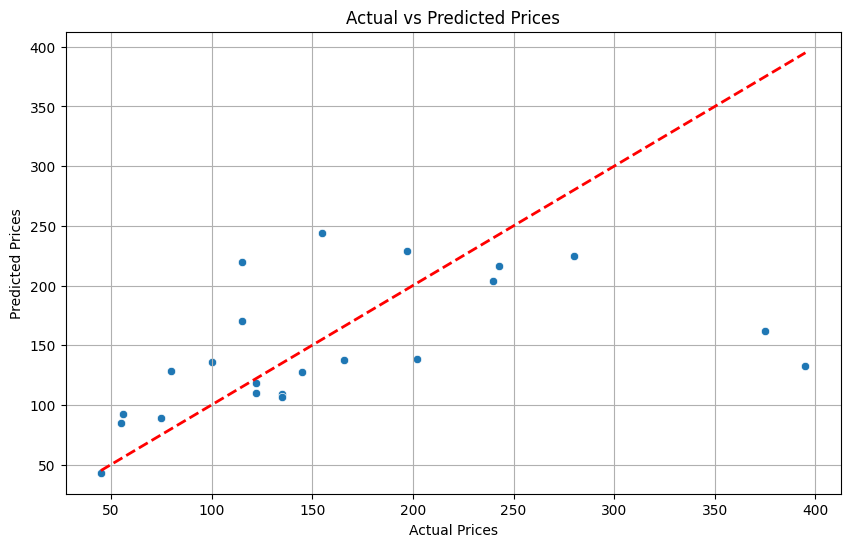

In [13]:
import seaborn as sns
# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=targs, y=preds)
plt.plot([targs.min(), targs.max()], [targs.min(), targs.max()], 'r--', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()